In [3]:
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt

from aiphysim.opts import Opts
from aiphysim.trainer import Trainer

from aiphysim.utils import (
    load_opts,
    make_output_dir,
    resolve
)

In [ ]:
# train
opts = load_opts("./config/opts.yaml",  "discrete")
opts.output_path = make_output_dir(opts.output_path, dev=False)
trainer = Trainer(opts)
trainer.setup()
trainer.train()


In [4]:
# load the best model
opts = load_opts("./config/opts.yaml",  "discrete")
opts.output_path = resolve("./runs/v0-musing-visvesvaraya")
trainer = Trainer(opts)
trainer.setup()
trainer.load("./runs/v0-musing-visvesvaraya/best.ckpt")


Loading parameters from /home/mila/g/guptapra/deepkoopman/config/opts.yaml
Creating datasets from  /home/mila/g/guptapra/deepkoopman/datasets/DiscreteSpectrumExample
Using GPU: cuda

Model parameters use 0.0001 GB
Number of parameters:
  • encoder        : 17283
  • decoder        : 17282
  • auxiliary      : 646
total              : 35211


In [13]:
# trajectories (downlaod the trajectory here - https://github.com/BethanyL/DeepKoopman/blob/master/postprocessing/DiscreteSpectrumExampleTrajs.csv)
trajs = np.loadtxt('DiscreteSpectrumExampleTrajs.csv', delimiter=',')

trajs  = trajs.reshape((trajs.shape[0],int(trajs.shape[1]/2), 2))

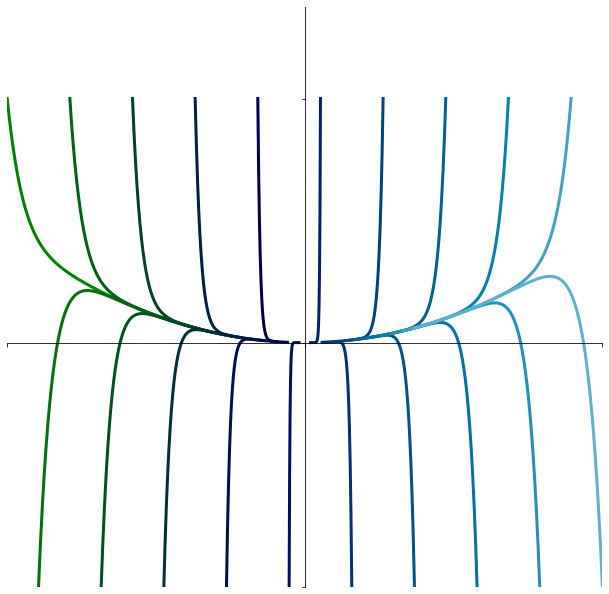

In [29]:
## Code copied from  - https://github.com/BethanyL/DeepKoopman/blob/master/postprocessing/BestModel-DiscreteSpectrumExample.ipynb
# We plot some nice trajectories from this system
# Left side of Figure 3
# create a special color map (version of ocean color map)
start = 0.0
stop = 1.0
number_of_lines= 25 
cm_subsection = np.linspace(start, stop, number_of_lines) 

colors = [ cm.ocean(x) for x in cm_subsection ]

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(16/3*2)
fig.set_figheight(16/3*2)

for j in np.arange(trajs.shape[0]):
    temp = trajs[j,:,:].copy()
    plt.plot(temp[:,0],temp[:,1], color=colors[j], linewidth=3)
    
xlab = [-.4,0,.4]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.4, 0, .4]
plt.yticks(ylab, xlabels)
plt.ylim([-.4, .55])
plt.xlim([-.4, .4])
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

In [30]:
import torch
n_steps = trajs.shape[1]
with torch.no_grad():
    initial_states = torch.tensor(trajs[:, 0, ...], dtype=torch.float32).to(trainer.device)
    _, intermediate_states = trainer.model.infer_trajectory(initial_states, n_steps)

trajs_yk = initial_states.clone().unsqueeze(1)
intermediate_states = torch.cat([s.unsqueeze(1) for s in intermediate_states], 1)
# batch x time x dim
trajs_yk = torch.cat([trajs_yk, intermediate_states], 1).cpu().numpy()



([<matplotlib.axis.YTick at 0x7f889d51c290>,
 [Text(0, -0.15, ''), Text(0, 0.0, ''), Text(0, 0.2, '')])

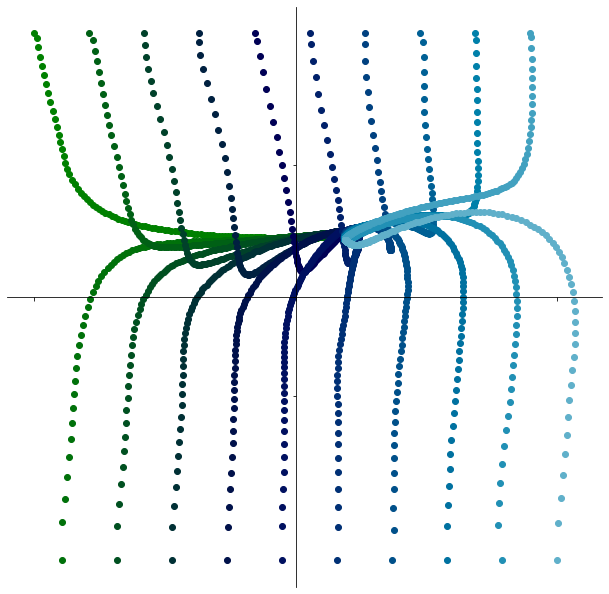

In [31]:
### ## Code copied from  - https://github.com/BethanyL/DeepKoopman/blob/master/postprocessing/BestModel-DiscreteSpectrumExample.ipynb
# Right side of Figure 3
# to check if really linear, 
# compare normalized eval^k (k = 0, 1, ...) to the y-coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(16/3*2)
fig.set_figheight(16/3*2)

subset = np.arange(0,trajs.shape[1],4)

for j in np.arange(trajs.shape[0]):
    scale0 = trajs_yk[j,0,0]
    scale1 = trajs_yk[j,0,1]
#     plt.plot(np.array(trajs_lambdas[j,:,0]*scale0), np.array(trajs_lambdas[j,:,1]*scale1), 'k', linewidth=2)
    ax.scatter(np.array(trajs_yk[j,subset,0]),np.array(trajs_yk[j,subset,1]), color=colors[j])

    
#plt.axis('equal')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
xlab = [-.4,0,.4]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.15, 0, .2]
plt.yticks(ylab, xlabels)

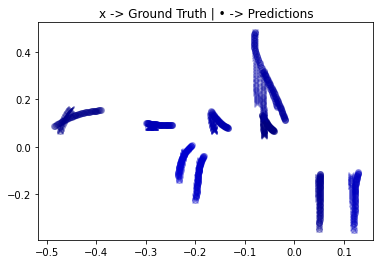

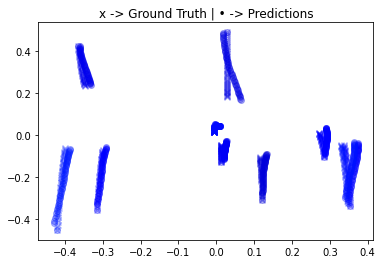

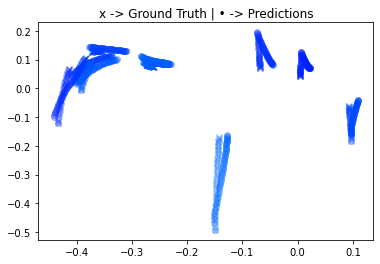

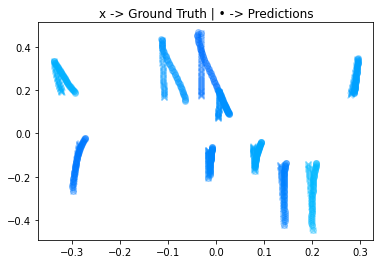

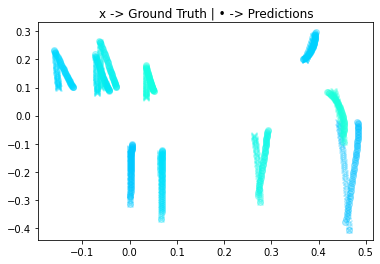

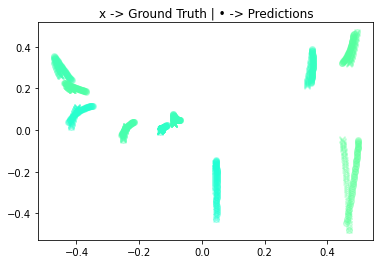

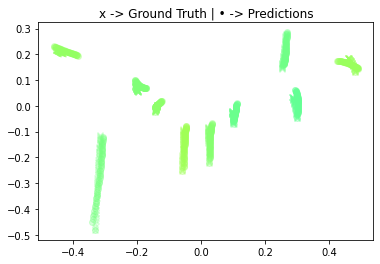

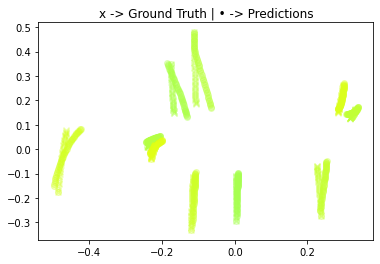

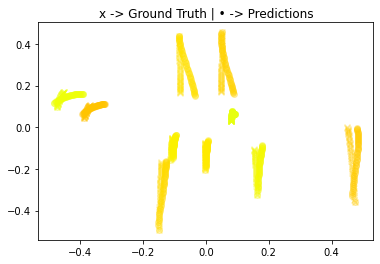

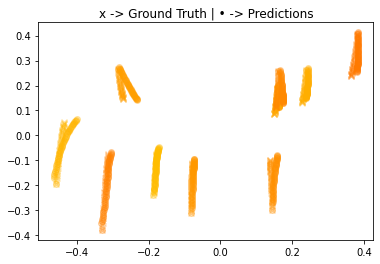

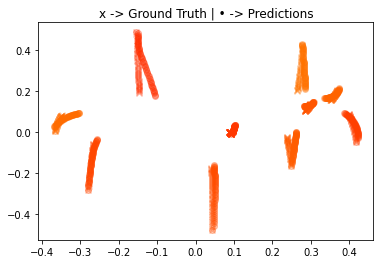

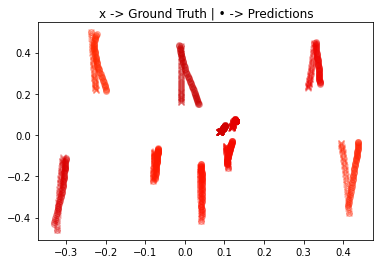

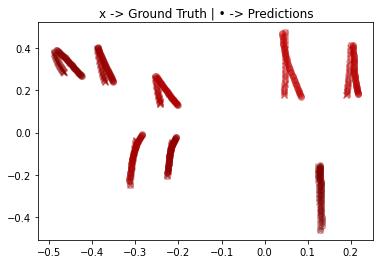

In [7]:
from koop.eval import plot_2D_comparative_trajectories
self = trainer

batch = next(iter(self.loaders["val"])).to(trainer.device)
val_trajs_len = (
    self.opts.val_trajectories.length
    if self.opts.val_trajectories.length > 0
    else self.opts.sequence_length
)

plot_2D_comparative_trajectories(trainer.model,
                batch,
                50,
                self.opts.val_trajectories.n_per_plot,
                self.exp,
                self.opts.output_path / "final_traj_plot.png",
 )